[View in Colaboratory](https://colab.research.google.com/github/hsarena/deeplearning/blob/master/deep_generative_mnist.ipynb)

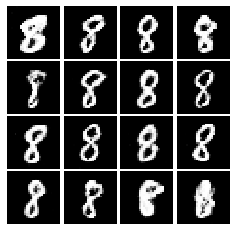

Iter: 19500
D loss: 0.03575
G_loss: 5.513



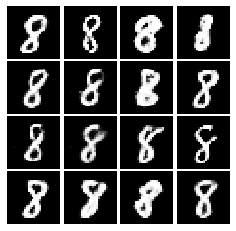

Iter: 19600
D loss: 0.06464
G_loss: 4.357



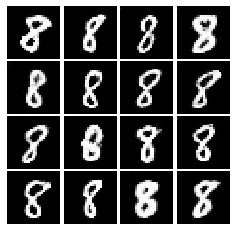

Iter: 19700
D loss: 0.03965
G_loss: 5.388



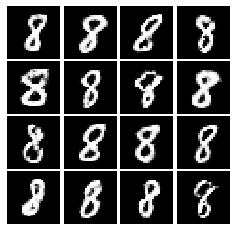

Iter: 19800
D loss: 0.1417
G_loss: 4.505



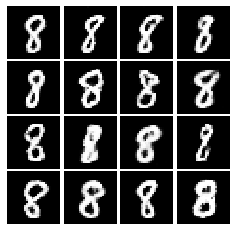

Iter: 19900
D loss: 0.05331
G_loss: 5.802



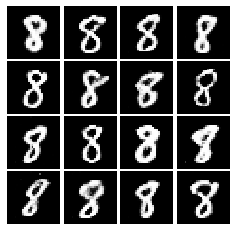

Iter: 20000
D loss: 0.07755
G_loss: 4.87



In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 100])

G_W1 = tf.Variable(xavier_init([100, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]


DC_D_W1 = tf.Variable(xavier_init([5, 5, 1, 16]))
DC_D_b1 = tf.Variable(tf.zeros(shape=[16]))

DC_D_W2 = tf.Variable(xavier_init([3, 3, 16, 32]))
DC_D_b2 = tf.Variable(tf.zeros(shape=[32]))

DC_D_W3 = tf.Variable(xavier_init([7 * 7 * 32, 128]))
DC_D_b3 = tf.Variable(tf.zeros(shape=[128]))

DC_D_W4 = tf.Variable(xavier_init([128, 1]))
DC_D_b4 = tf.Variable(tf.zeros(shape=[1]))

theta_DC_D = [DC_D_W1, DC_D_b1, DC_D_W2, DC_D_b2, DC_D_W3, DC_D_b3, DC_D_W4, DC_D_b4]


def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def dc_generator(z):
    pass


def dc_discriminator(x):
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    conv1 = tf.nn.relu(tf.nn.conv2d(x, DC_D_W1, strides=[1, 2, 2, 1], padding='SAME') + DC_D_b1)
    conv2 = tf.nn.relu(tf.nn.conv2d(conv1, DC_D_W2, strides=[1, 2, 2, 1], padding='SAME') + DC_D_b2)
    conv2 = tf.reshape(conv2, shape=[-1, 7 * 7 * 32])
    h = tf.nn.relu(tf.matmul(conv2, DC_D_W3) + DC_D_b3)
    logit = tf.matmul(h, DC_D_W4) + DC_D_b4
    prob = tf.nn.sigmoid(logit)

    return prob, logit


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


G_sample = generator(Z)
D_real, D_logit_real = dc_discriminator(X)
D_fake, D_logit_fake = dc_discriminator(G_sample)

#D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
#G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_DC_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

mb_size = 128
Z_dim = 100

#mnist = input_data.read_data_sets('../data/MNIST_data', one_hot=True)
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

sess = tf.Session()
sess.run(tf.initialize_all_variables())

if not os.path.exists('../out/'):
    os.makedirs('../out/')

i = 0

for it in range(100000):
    if it % 100 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

        fig = plot(samples)
        plt.show(fig)
        plt.savefig('../out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 100 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()